In [66]:
import hashlib
import os
import requests


In [67]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
import seaborn as sns 

In [68]:
train_data = pd.read_csv("E:\\Galaxy\\House_prices\\data\\house-prices-advanced-regression-techniques\\train.csv")
test_data = pd.read_csv("E:\\Galaxy\\House_prices\\data\\house-prices-advanced-regression-techniques\\test.csv")

In [69]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


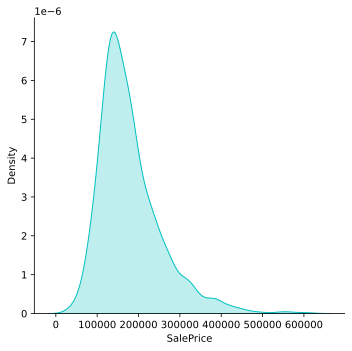

In [95]:
sns.displot(train_data['SalePrice'], kind='kde',
            fill = True, color = 'c')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

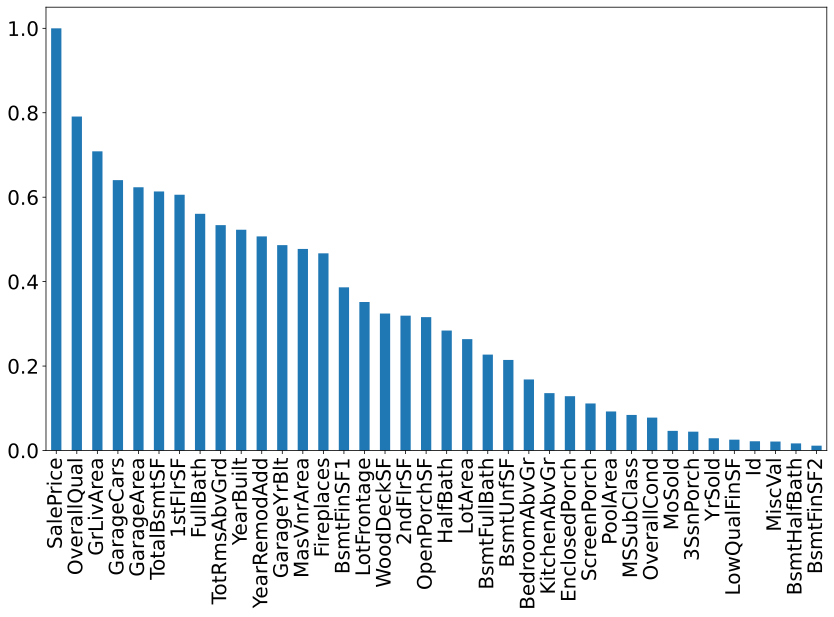

In [70]:
fig = plt.figure(figsize=(14,8))
abs(train_data.corr()['SalePrice']).sort_values(ascending=False).plot.bar()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

<Figure size 350x250 with 0 Axes>

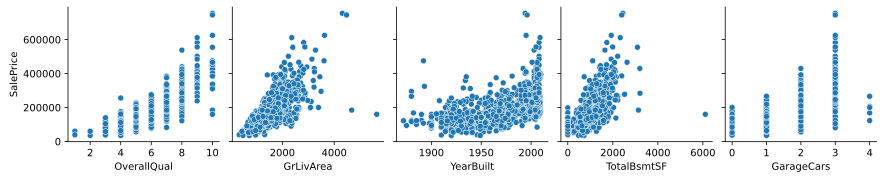

In [71]:
#异常值处理
figure=plt.figure()
sns.pairplot(x_vars=['OverallQual','GrLivArea','YearBuilt','TotalBsmtSF', 'GarageCars'],
             y_vars=['SalePrice'],data=train_data,dropna=True)
plt.show()

In [72]:
#删除异常值
train_data = train_data.drop(train_data[(train_data['OverallQual']<5) &
                                        (train_data['SalePrice']>200000)].index)
 
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) &
                                        (train_data['SalePrice']<300000)].index)
 
train_data = train_data.drop(train_data[(train_data['YearBuilt']<1900) &
                                        (train_data['SalePrice']>400000)].index)
train_data = train_data.drop(train_data[(train_data['TotalBsmtSF']>6000) &
                                        (train_data['SalePrice']<200000)].index)
train_data = train_data.drop(train_data[(train_data['GarageCars']==3) &
                                        (train_data['SalePrice']>620000)].index)

<Figure size 350x250 with 0 Axes>

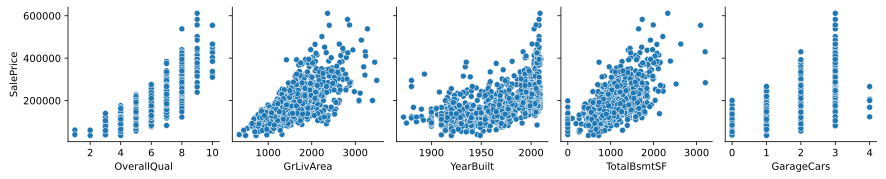

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [73]:
figure=plt.figure()
sns.pairplot(x_vars=['OverallQual','GrLivArea','YearBuilt','TotalBsmtSF', 'GarageCars'],
             y_vars=['SalePrice'],data=train_data,dropna=True)
plt.show()

print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

In [74]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

#观察数据的缺失情况
nan_index=((all_features.isnull().sum()/len(all_features))).sort_values(ascending=False)#34个缺失值

In [75]:
# 数据预处理 非object数据
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [76]:
all_features.shape

(2912, 79)

In [77]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
# 将离散型特征的每一种取值都看成一种状态，若你的这一特征中有N个不相同的取值
# 我们就可以将该特征抽象成N种不同的状态
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2912, 330)

In [78]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32
)

## [**训练**]

In [79]:
loss = nn.MSELoss()
in_features = train_features.shape[1]   # 331

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

这使得预测价格的对数与真实标签价格的对数之间出现以下均方根误差：

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$

In [80]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

[**我们的训练函数将借助Adam优化器**]

In [81]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)

    optimizer = torch.optim.Adam(net.parameters(),
                            lr = learning_rate,
                            weight_decay = weight_decay)


    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls



## $K$折交叉验证

In [82]:
# 获取k折交叉验证某一折的训练集和验证集
def get_k_fold_data(k, i, X, y):
    assert k > 1

    fold_size = X.shape[0] // k     # 每份的个数:数据总条数/折数（组数）
    X_train, y_train = None, None   # X_train为训练集，y_valid为验证集
    for j in range(k):
        idx = slice(j * fold_size, (j+1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:          
            # i为当前折, 则把该折作为验证集
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)   # 按维数0（行）拼接
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

当我们在$K$折交叉验证中训练$K$次后，[**返回训练和验证误差的平均值**]。

In [83]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, 
                                    weight_decay, batch_size) 
                                    # *是解码，变成前面返回的四个数据
                                    # [-1]返回的每一折的最后一次epoch的损失值
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}, 训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k        

折1, 训练log rmse0.162813, 验证log rmse0.157350
折2, 训练log rmse0.160276, 验证log rmse0.154823
折3, 训练log rmse0.149487, 验证log rmse0.203606
折4, 训练log rmse0.158898, 验证log rmse0.138548
折5, 训练log rmse0.158792, 验证log rmse0.157169
折6, 训练log rmse0.160043, 验证log rmse0.156355
6-折验证: 平均训练log rmse: 0.158385, 平均验证log rmse: 0.161309


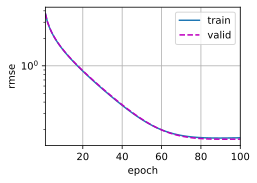

In [96]:
k, num_epochs, lr, weight_decay, batch_size = 6, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [97]:
#模型预测
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])

训练log rmse：0.156365


,Id,SalePrice
0,1461,120464.671875
1,1462,157230.203125
2,1463,198099.984375
3,1464,216085.671875
4,1465,176324.250000


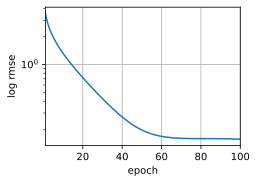

In [98]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)
submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
submission.to_csv("E:\\Galaxy\\House_prices\\submission.csv",index=False) 
submission.head()